## Starting Example
Here we will load the UR10 manipulator and load it into the Meshcat visualiser with a desired configuration. You should see a new window open in your browser displaying the arm in its default state.

In [299]:
import casadi
import numpy as np

import pinocchio as pin
import pinocchio.casadi as cpin

import time

from example_robot_data import load

robot = load('ur10')

# Select the default configuration for the robot.
q0 = robot.q0
# OPTIONAL - Instead, choose a random configuration within the configuration space of the model
# q0 = pin.randomConfiguration(robot.model)

## visualise the robot
import meshcat
from pinocchio.visualize import MeshcatVisualizer
viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
# Start a new MeshCat server and client.
viz.initViewer(open=True)
# Load the robot in the viewer.
viz.loadViewerModel()
# Display the robot with the initial state q0
viz.display(q0)

# Display reference as a transparent red model
viz_ref = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz_ref.initViewer(viz.viewer)
viz_ref.loadViewerModel(rootNodeName="reference", color=[1.0, 0.0, 0.0, 0.1])

# small time window for loading the model 
time.sleep(0.2)

# Add simulation functions, making use of rigid-body dynamics algorithms

# Forward-stepping of the dynamics
def step(robot, q, v, u, dt):
    # Compute forward dynamics, include a little joint damping
    a = pin.aba(robot.model, robot.data, q, v, u) - 0.1 * v
    v = v + dt * a
    q = pin.integrate(robot.model, q, dt * v)
    return (q, v)


# Displaying a model
def display(viz, q, i, fps, dt):
    i_skip = int((1.0 / fps) / dt)
    if i % i_skip == 0:
        viz.display(q)
        time.sleep(dt)

# Displaying a model
def render_flag(i, fps, dt):
    i_skip = int((1.0 / fps) / dt)
    if i % i_skip == 0:
        return True
    else:
        return False

# State of the robot
q = robot.q0
v = np.zeros(robot.nv)
a = np.zeros(robot.nv)
tau = np.zeros(robot.nv)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7027/static/


# Simulating the Dynamics Without Control
We will now use the rigid-body dynamics algorithms to forward-compute the dynamics of the robot from an initial state. When there is no joint stiffness or damping, the system will behave chaotically.

We are not accounting for collisions in this tutorial, as this would require a sophisticated physic simulator to handle the dynamics of contact, Meshcat is simply displaying the configuration of the robot.

In [300]:
def default_reference(robot, t, q, v):
    return (robot.q0, np.zeros(robot.nv))

def null_control(robot, t, q, v, qr, vr):
    return np.zeros(robot.nv)


# Simulate the system for 5 seconds
T = 5.0
dt = 1e-5
t = 0.0
# Iteration counter
it = 0
while t <= T:
    (qr, vr) = default_reference(robot, t, q, v)
    tau = null_control(robot, t, q, v, qr, vr)
    (q, v) = step(robot, q, v, tau, dt)
    display(viz, q, it, 30.0, dt)
    t += dt
    it += 1

## PD Joint Control
To track a nominal state, we can introduce virtual spring-damping to each joint by using a PD controller to act at each joint proportional to the error and error rate at each time step, much like in Lecture 1. 

<b>Note :</b> We are not using integral control here for convenience.

In [301]:
def pd_reference(robot, t, q, v):
    qr = robot.q0.copy()
    # Provide sinusoidal generation to select joints
    qr[0] = robot.q0[0] + 1.5 * np.sin(t)
    qr[1] = robot.q0[1] - 1.0 + 0.2 * np.sin(t)
    qr[2] = robot.q0[2] - 1.5 * np.sin(t)
    vr = np.zeros(robot.nv)
    return (qr, vr)

# Control Law u = Kp (q - qr) + Kd (v - vr)
def pd_controller(robot, t, q, v, qr, vr):
    # Define gains
    Kp = 300 * np.diag(np.ones(robot.nq))
    Kd = 10 * np.diag(np.ones(robot.nv))
    return Kp.dot(qr - q) + Kd.dot(vr - v)

# Simulate the system for 5 seconds
T = 10.0
dt = 1e-5
t = 0.0
# Iteration counter
it = 0
while t <= T:
    (qr, vr) = pd_reference(robot, t, q, v)
    tau = pd_controller(robot, t, q, v, qr, vr)
    (q, v) = step(robot, q, v, tau, dt)
    display(viz, q, it, 30.0, dt)
    display(viz_ref, qr, it, 30.0, dt)
    t += dt
    it += 1

## Computed Torque Control
That wasn't very good, was it? It looks as though our controller doesn't know the robot arm has weight, which is exactly what is happening. Let us instead view the controller from an acceleration perspective, if we can compute torques that achieve a desired acceleration in the joints, we can make this desired acceleration our error terms. We can then choose accelerations that are dynamically consistent with the robot, such that they also account for the dynamics of the robot.

In [302]:
def ct_reference(robot, t, q, v):
    qr = robot.q0.copy()
    # Provide sinusoidal generation to select joints
    qr[0] = robot.q0[0] + 1.5 * np.sin(t)
    qr[1] = robot.q0[1] - 1.0 + 0.2 * np.sin(t)
    qr[2] = robot.q0[2] - 1.5 * np.sin(t)
    vr = np.zeros(robot.nv)
    return (qr, vr)

def ct_controller(robot, t, q, v, qr, vr):
    # Define a reference
    ar = np.zeros(robot.nv)

    Kp = 300.0 * np.diag(np.ones(robot.nv))
    Kd = 10.0 * np.diag(np.ones(robot.nv))

    # Set desired acceleration of the system as the PD error of the state
    ad = ar + Kp.dot(qr - q) + Kd.dot(vr - v)

    # Compute control inputs that would realise this acceleration on the model, accounting for its dynamics
    return pin.rnea(robot.model, robot.data, q, v, ad)

# Simulate the system for 5 seconds
T = 10.0
dt = 1e-5
t = 0.0
# Iteration counter
it = 0
while t <= T:
    (qr, vr) = ct_reference(robot, t, q, v)
    tau = ct_controller(robot, t, q, v, qr, vr)
    (q, v) = step(robot, q, v, tau, dt)
    display(viz, q, it, 30.0, dt)
    display(viz_ref, qr, it, 30.0, dt)
    t += dt
    it += 1

As you can see, the dynamics are now accounted for in the controller, thus the robot hardly moves. It should be noted this is a perfect simulation, where we know the dynamics of the robot exactly, if the models differ significantly, the behaviour may grow unstable.

## Operational Space Control
Moving the arm to any arbitrary point in space can be difficult from a computed torque perspective, as we need to know what joint configuration is required. 

Operational space control allows us to specify tasks that the robot needs to perform, and computes a torque to achieve it. This can range from positional tasks and impedance control (specify a desired force or spring-damper-like behaviour) to more abstract goals such as stability criterion and centre of mass tracking.

Continuing with our UR10 example, we will make the robot follow a specified trajectory in space using operational space control.

In [303]:
def ts_reference(robot, t, xpos, xvel):
    return (np.array([0.8 + 0.3 * np.sin(0.5 * t), 0.0, 0 + 0.3 * np.cos(0.5 * t)]), np.array([0.0, 0.0, 0.0]))


def ts_controller(robot, t, q, v, xpos_r, xvel_r):
    # Get the ID of the end-effector (ee) frame that we wish to control
    ee_id = robot.model.getFrameId('tool0')

    # Compute the forward kinematics of the system (i.e. all frame positions and velocities)
    pin.framesForwardKinematics(robot.model, robot.data, q)

    # Get the Jacobian of the position in space
    pin.computeJointJacobians(robot.model, robot.data, q)
    J = pin.getFrameJacobian(robot.model, robot.data, ee_id, pin.LOCAL)[0:3, :]

    # Get the time derivative of the frame Jacobian
    pin.computeJointJacobiansTimeVariation(robot.model, robot.data, q, v)
    pin.updateFramePlacements(robot.model, robot.data)
    dJ = pin.getFrameJacobianTimeVariation(robot.model, robot.data, ee_id, pin.LOCAL)[0:3, :]

    # Set desired frame location (world-aligned frame with offset specified by xpos_r)
    pdes = pin.SE3.Identity()
    pdes.translation = xpos_r
    # Compute difference between frames
    dMf = robot.data.oMf[ee_id].actInv(pdes)
    # Get the frame velocity
    xd = pin.getFrameVelocity(robot.model, robot.data, ee_id, pin.LOCAL)

    # Error
    e = pin.log6(dMf).vector[0:3]
    # Error rate
    de = xd.vector[0:3]

    # These PD gains are now in task-space, this provides a further level of abstraction
    Kp = np.diag([50.0, 50.0, 50.0])
    Kd = np.diag([10.0, 10.0, 10.0])

    # Task space acceleration
    xacc_d = Kp.dot(e) - Kd.dot(de)

    M = pin.crba(robot.model, robot.data, q)
    invM = np.linalg.inv(M)

    h = pin.rnea(robot.model, robot.data, q, v, np.zeros(robot.nv))

    # We employ a null-space approach for end-effector tracking, adding joint damping as a null-space task to compensate for our 
    # poor simulation environment
    # Based on this approach - https://www.ncbi.nlm.nih.gov/books/NBK299036/#ch6_Eq_6_8
    JT = np.transpose(J)
    JMJ = J.dot(invM.dot(JT))

    invJMJ = np.linalg.inv(JMJ)
    Jbar = invM.dot(JT.dot(invJMJ))
    pinvJ = np.linalg.pinv(J)

    JJ = JT.dot(np.transpose(Jbar))
    I = np.eye(robot.nv)

    N = I - JJ

    Dj = np.diag([5.0, 5.0, 5.0, 5.0, 5.0, 5.0])

    tau = JJ.dot(M.dot(pinvJ.dot(xacc_d - dJ.dot(v)))) + N.dot(- Dj.dot(v)) + h 
        
    # Compute the required torque
    return tau

# Reset state of system
q = robot.q0
v = np.zeros(robot.nv)
a = np.zeros(robot.nv)
tau = np.zeros(robot.nv)

# Provide a visualisation of the reference point
import meshcat.geometry as g
viz.viewer["ref"].set_object(meshcat.geometry.Sphere(0.02), g.MeshLambertMaterial(
                             color=0xff0000,
                             reflectivity=0.0))

T = 30.0
dt = 1e-4
t = 0.0
# Iteration counter
it = 0
while t <= T:
    (xr, dxr) = ts_reference(robot, t, q, v)
    tau = ts_controller(robot, t, q, v, xr, dxr)
    (q, v) = step(robot, q, v, tau, dt)
    if render_flag(it, 30.0, dt):
        viz.display(q)
        viz.viewer["ref"].set_transform(meshcat.transformations.translation_matrix(xr))
    t += dt
    it += 1

# Remove reference
viz.viewer["ref"].delete()

# MPC Methods

We also provide a toy example from the automatic differentiation library CasADi, where the motion of a race car is computed.

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:      903
Number of nonzeros in inequality constraint Jacobian.:      303
Number of nonzeros in Lagrangian Hessian.............:      302

Total number of variables............................:      303
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      203
Total number of inequality constraints...............:      202
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:      100
        inequality constraints with only upper bounds:      101

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 1.00e+00 4.09e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

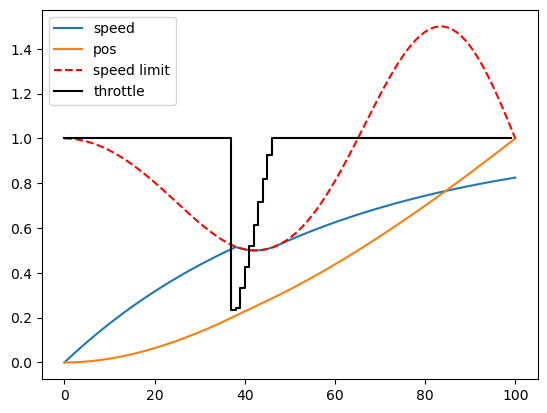

In [304]:
# Car race along a track
# ----------------------
# An optimal control problem (OCP),
# solved with direct multiple-shooting.
#
# For more information see: http://labs.casadi.org/OCP
from casadi import *

N = 100 # number of control intervals

opti = Opti() # Optimization problem

# ---- decision variables ---------
X = opti.variable(2,N+1) # state trajectory
pos   = X[0,:]
speed = X[1,:]
U = opti.variable(1,N)   # control trajectory (throttle)
T = opti.variable()      # final time

# ---- objective          ---------
opti.minimize(T) # race in minimal time

# ---- dynamic constraints --------
f = lambda x,u: vertcat(x[1],u-x[1]) # dx/dt = f(x,u)

dt = T/N # length of a control interval
for k in range(N): # loop over control intervals
   # Runge-Kutta 4 integration
   k1 = f(X[:,k],            U[:,k])
   k2 = f(X[:,k]+ dt/2 * k1, U[:,k])
   k3 = f(X[:,k]+ dt/2 * k2, U[:,k])
   k4 = f(X[:,k]+ dt * k3,   U[:,k])
   x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
   opti.subject_to(X[:,k+1]==x_next) # close the gaps

# ---- path constraints -----------
limit = lambda pos: 1-sin(2*pi*pos)/2
opti.subject_to(speed<=limit(pos))   # track speed limit
opti.subject_to(opti.bounded(0,U,1)) # control is limited

# ---- boundary conditions --------
opti.subject_to(pos[0]==0)   # start at position 0 ...
opti.subject_to(speed[0]==0) # ... from stand-still 
opti.subject_to(pos[-1]==1)  # finish line at position 1

# ---- misc. constraints  ----------
opti.subject_to(T>=0) # Time must be positive

# ---- initial values for solver ---
opti.set_initial(speed, 1)
opti.set_initial(T, 1)

# ---- solve NLP              ------
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve

# ---- post-processing        ------
from pylab import plot, step, figure, legend, show, spy

plot(sol.value(speed),label="speed")
plot(sol.value(pos),label="pos")
plot(limit(sol.value(pos)),'r--',label="speed limit")
step(range(N),sol.value(U),'k',label="throttle")
legend(loc="upper left")

show()

We now show an example from the Pinocchio github repository that demonstrates how to create an optimal control problem interfacing with CasADi

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:    13746
Number of nonzeros in inequality constraint Jacobian.:      320
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1292
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      984
Total number of inequality constraints...............:      320
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      320
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.50e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

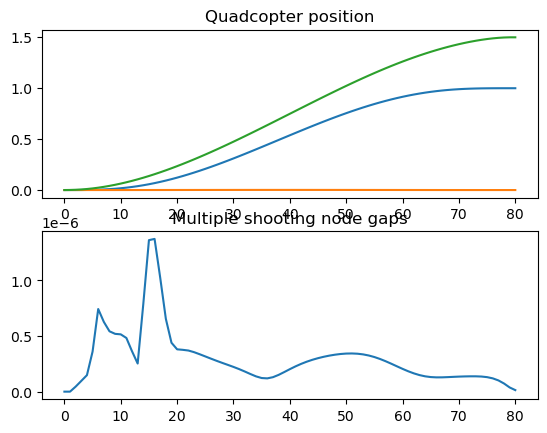

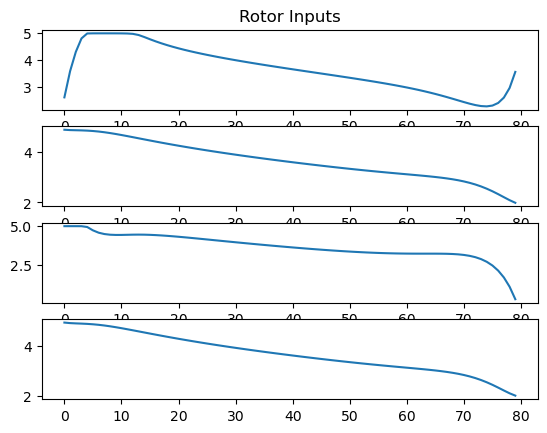

In [306]:
# Example from Pinocchio (https://github.com/stack-of-tasks/pinocchio/blob/master/examples/casadi-quadrotor-ocp.py)

import sys
from os.path import dirname, join, abspath

import casadi
import numpy as np

import pinocchio as pin
import pinocchio.casadi as cpin


# Problem parameters
x_goal = [1, 0, 1.5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
x0 = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
nodes = 80
dt = 0.02

# Quadcopter parameters
d_cog, cf, cm = 0.1525, 6.6e-5, 1e-6

tau_f = np.array(
    [
        [0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0],
        [1.0, 1.0, 1.0, 1.0],
        [0.0, d_cog, 0.0, -d_cog],
        [-d_cog, 0.0, d_cog, 0.0],
        [-cm / cf, cm / cf, -cm / cf, cm / cf],
    ]
)

# Other variables
x_nom = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


def actuation_model():
    u = casadi.SX.sym("u", 4)  # rotor velocities
    tau = tau_f @ u

    return casadi.Function("act_model", [u], [tau], ["u"], ["tau"])


def state_integrate(model):
    q = casadi.SX.sym("dq", model.nq)
    dq = casadi.SX.sym("q", model.nv)
    v = casadi.SX.sym("v", model.nv)
    dv = casadi.SX.sym("dv", model.nv)

    q_next = cpin.integrate(model, q, dq)
    v_next = v + dv

    dx = casadi.vertcat(dq, dv)
    x = casadi.vertcat(q, v)
    x_next = casadi.vertcat(q_next, v_next)

    return casadi.Function("integrate", [x, dx], [x_next], ["x", "dx"], ["x_next"])


def state_difference(model):
    q0 = casadi.SX.sym("q0", model.nq)
    q1 = casadi.SX.sym("q1", model.nq)
    v0 = casadi.SX.sym("v0", model.nv)
    v1 = casadi.SX.sym("v1", model.nv)

    q_diff = cpin.difference(model, q0, q1)
    v_diff = v1 - v0

    x0 = casadi.vertcat(q0, v0)
    x1 = casadi.vertcat(q1, v1)
    x_diff = casadi.vertcat(q_diff, v_diff)

    return casadi.Function("difference", [x0, x1], [x_diff], ["x0", "x1"], ["x_diff"])


def euler_integration(model, data, dt):
    nu = 4
    u = casadi.SX.sym("u", nu)

    # tau = casadi.vertcat(np.zeros(model.nv - nu), u)
    tau = actuation_model()(u)

    q = casadi.SX.sym("q", model.nq)
    v = casadi.SX.sym("v", model.nv)

    a = cpin.aba(model, data, q, v, tau)

    dq = v * dt + a * dt**2
    dv = a * dt

    x = casadi.vertcat(q, v)
    dx = casadi.vertcat(dq, dv)
    x_next = state_integrate(model)(x, dx)

    return casadi.Function("int_dyn", [x, u], [x_next], ["x", "u"], ["x_next"])


def cost_quadratic_state_error(model):
    dx = casadi.SX.sym("dx", model.nv * 2)

    x_N = state_integrate(model)(x_nom, dx)
    e_goal = state_difference(model)(x_N, x_goal)

    cost = 0.5 * e_goal.T @ e_goal

    return casadi.Function("quad_cost", [dx], [cost], ["dx"], ["cost"])


class OptimalControlProblem:
    def __init__(self, model, terminal_soft_constraint=False):
        self.opti = casadi.Opti()

        self.model = model
        self.data = self.model.createData()

        self.c_model = cpin.Model(self.model)
        self.c_data = self.c_model.createData()

        nv = self.c_model.nv
        nu = 4

        self.c_dxs = self.opti.variable(2 * nv, nodes + 1)  # state trajectory
        self.c_us = self.opti.variable(nu, nodes)  # control trajectory

        # Objective function
        obj = 0

        # State & Control regularization
        for i in range(nodes):
            x_i = state_integrate(self.c_model)(x_nom, self.c_dxs[:, i])
            e_reg = state_difference(self.c_model)(x_nom, x_i)
            obj += (
                1e-5 * 0.5 * e_reg.T @ e_reg
                + 1e-5 * 0.5 * self.c_us[:, i].T @ self.c_us[:, i]
            )
        if terminal_soft_constraint:
            obj += 1000 * cost_quadratic_state_error(self.c_model)(self.c_dxs[:, nodes])

        self.opti.minimize(obj)

        # Dynamical constraints
        for i in range(nodes):
            x_i = state_integrate(self.c_model)(x_nom, self.c_dxs[:, i])
            x_i_1 = state_integrate(self.c_model)(x_nom, self.c_dxs[:, i + 1])
            f_x_u = euler_integration(self.c_model, self.c_data, dt)(
                x_i, self.c_us[:, i]
            )
            gap = state_difference(self.c_model)(f_x_u, x_i_1)

            self.opti.subject_to(gap == [0] * 12)

        # Control constraints
        self.opti.subject_to(self.opti.bounded(0, self.c_us, 5))

        # Final constraint
        if not terminal_soft_constraint:
            x_N = state_integrate(self.c_model)(x_nom, self.c_dxs[:, nodes])
            e_goal = state_difference(self.c_model)(x_N, x_goal)
            self.opti.subject_to(e_goal == [0] * 12)

        # Initial state
        x_0 = state_integrate(self.c_model)(x_nom, self.c_dxs[:, 0])
        self.opti.subject_to(state_difference(self.c_model)(x0, x_0) == [0] * 12)

        # Warm start
        self.opti.set_initial(
            self.c_dxs, np.vstack([np.zeros(12) for _ in range(nodes + 1)]).T
        )
        self.opti.set_initial(
            self.c_us, np.vstack([np.zeros(4) for _ in range(nodes)]).T
        )

    def solve(self, approx_hessian=True):
        opts = {"verbose": False}
        opts["ipopt"] = {
            "max_iter": 1000,
            "linear_solver": "mumps",
            "tol": 3.82e-6,
            "mu_strategy": "adaptive",
        }

        if approx_hessian:
            opts["ipopt"]["hessian_approximation"] = "limited-memory"

        # Solver initialization
        self.opti.solver("ipopt", opts)  # set numerical backend

        try:
            self.sol = self.opti.solve()
        except:
            self.sol = self.opti.debug

        if self.sol.stats()["return_status"] == "Solve_Succeeded":
            self._retract_trajectory()
            self._compute_gaps()

    def _retract_trajectory(self):
        self.xs = []
        self.us = []
        self.gaps = []

        nq = self.model.nq
        nv = self.model.nv

        for idx, (dx_sol, u_sol) in enumerate(
            zip(self.sol.value(self.c_dxs).T, self.sol.value(self.c_us).T)
        ):
            q = pin.integrate(self.model, np.array(x_nom)[:nq], dx_sol[:nv])
            v = dx_sol[nv:]

            self.xs.append(np.concatenate([q, v]))
            self.us.append(u_sol)

        q = pin.integrate(
            self.model, np.array(x_nom)[:nq], self.sol.value(self.c_dxs).T[nodes, :nv]
        )
        v = self.sol.value(self.c_dxs).T[nodes, nv:]
        self.xs.append(np.concatenate([q, v]))

    def _compute_gaps(self):
        self.gaps = {"vector": [np.zeros(self.model.nv * 2)], "norm": [0]}

        nq = self.model.nq
        nv = self.model.nv

        for idx, (x, u) in enumerate(zip(self.xs, self.us)):
            x_pin = self._simulate_step(x, u)

            gap_q = pin.difference(self.model, x_pin[:nq], self.xs[idx + 1][:nq])
            gap_v = self.xs[idx + 1][nq:] - x_pin[nq:]

            gap = np.concatenate([gap_q, gap_v])
            self.gaps["vector"].append(gap)
            self.gaps["norm"].append(np.linalg.norm(gap))

    def _simulate_step(self, x, u):
        nq = self.model.nq
        nv = self.model.nv

        q = x[:nq]
        v = x[nq:]

        tau = tau_f @ u

        a = pin.aba(self.model, self.data, q, v, tau)

        dq = v * dt + a * dt**2
        dv = a * dt

        q_next = pin.integrate(self.model, q, dq)
        v_next = v + dv

        x_next = np.concatenate([q_next, v_next])

        return x_next


def main():
    robot = load("hector")
    model = robot.model

    oc_problem = OptimalControlProblem(model, terminal_soft_constraint=False)

    oc_problem.solve(approx_hessian=True)

    # --------------PLOTS-----------
    import matplotlib.pyplot as plt

    fig0, axs0 = plt.subplots(nrows=2)

    xs = np.vstack(oc_problem.xs)
    axs0[0].plot(xs[:, :3])
    axs0[0].set_title("Quadcopter position")

    axs0[1].plot(oc_problem.gaps["norm"])
    axs0[1].set_title("Multiple shooting node gaps")

    fig1, axs1 = plt.subplots(nrows=4)
    us = np.vstack(oc_problem.us)

    for idx, ax in enumerate(axs1):
        ax.plot(us[:, idx])
    axs1[0].set_title("Rotor Inputs")
    

    plt.show(block=False)


if __name__ == "__main__":
    main()